In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score
import seaborn as sns # for visualisation
# ignoring the warnings
import warnings
warnings.filterwarnings('ignore')
!pip install boruta
from boruta import BorutaPy
tax_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/tax_payers/train_set_label.csv" )
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/tax_payers/test_set_label.csv')

In [38]:
tax_data.head()

,Unnamed: 0,HHI,HHDL,Married,CollegGrads,AHHAge,Cars,Filed in 2017,Filed in 2016,Filed in 2015,PoliticalParty
0,61,183414,-12402,1,2,28,1,0,0,1,Democrat
1,501,129786,700251,2,5,63,3,0,0,0,Republican
2,658,268343,493411,2,4,44,1,1,0,1,Independent
3,703,290506,-433408,1,1,28,5,1,0,1,Republican
4,702,90108,907135,1,3,57,5,1,1,0,Democrat


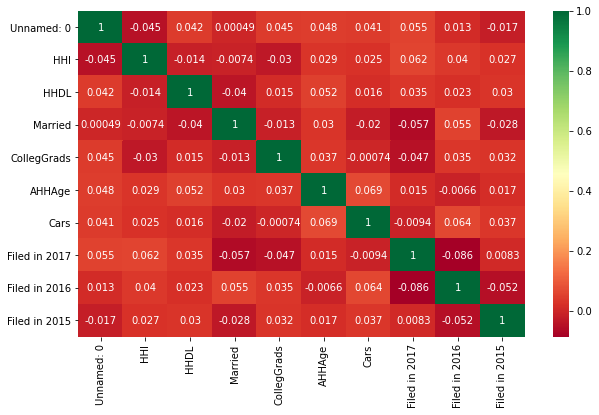

In [42]:
corrmat = tax_data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")

Index(['Unnamed: 0', 'HHI', 'HHDL', 'Married', 'CollegGrads', 'AHHAge', 'Cars',
       'Filed in 2017', 'Filed in 2016', 'Filed in 2015', 'PoliticalParty'],
      dtype='object')

In [43]:
X=tax_data.drop(['PoliticalParty'],axis=1)
#test_data=test_data.drop(['Filed in 2017', 'Filed in 2016','Married', 'CollegGrads', 'AHHAge', 'Filed in 2015'],axis=1)
Y=tax_data[['PoliticalParty']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [46]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state = 1)      
lr_baseline_model = clf_lr.fit(X_train,y_train)

In [49]:
y_pred = lr_baseline_model.predict(X_test)
# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
print("Baseline Model Accuracy:", ac)

Baseline Model Accuracy: 0.31840796019900497


In [51]:
from sklearn.feature_selection import RFE #importing RFE class from sklearn library

rfe = RFE(estimator= clf_lr , step = 1) 
# estimator clf_lr is the baseline model (basic model) that we have created under "Base line Model" selection
# step = 1: removes one feature at a time and then builds a model on the remaining features
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.
# we can even provide no. of features as an argument 

# Fit the function for ranking the features
fit = rfe.fit(X_train, y_train)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True  True False False  True  True  True False False False]
Feature Ranking: [1 1 6 4 1 1 1 2 5 3]


In [52]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,Unnamed: 0,1
1,HHI,1
4,CollegGrads,1
5,AHHAge,1
6,Cars,1
7,Filed in 2017,2
9,Filed in 2015,3
3,Married,4
8,Filed in 2016,5
2,HHDL,6


In [53]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting our baseline model with the transformed data
lr_rfe_model = clf_lr.fit(X_train_rfe, y_train)

In [55]:
#making predictions and evaluating the model
y_pred_rfe = lr_rfe_model.predict(X_test_rfe)

rfe_ac = accuracy_score(y_test, y_pred_rfe)
print("RFE Model Accuracy:", rfe_ac)

RFE Model Accuracy: 0.3333333333333333


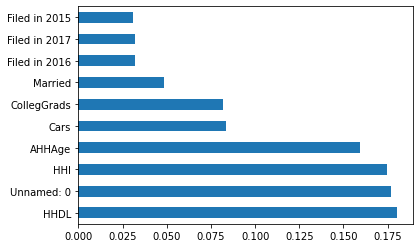

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf_clf = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# n_estimators = The number of trees in the forest.
# n_jobs = -1 : Use all processors for training

# Train the classifier
rf_clf.fit(X_train, y_train)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [57]:
from sklearn.feature_selection import SelectFromModel
# Create a selector object that will use the random forest classifier to identify
# It will select the features based on the importance score
rf_sfm = SelectFromModel(rf_clf)

#Alternatively if you want to set a specific threshold and select the features you may the following code that is commented
# features that have an importance of more than 0.13 ( all top 4 features lie above this)
# rf_sfm = SelectFromModel(rf_clf, threshold=0.13)

# Train the selector
rf_sfm = rf_sfm.fit(X_train, y_train)

In [58]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = rf_sfm.transform(X_train)
X_important_test = rf_sfm.transform(X_test)

In [59]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important = clf_important.fit(X_important_train, y_train)

In [60]:
y_pred = rf_clf.predict(X_test)
rf_ac = accuracy_score(y_test, y_pred)
# View The Accuracy Of Our Full Feature (8 Features) Model
print("Baseline Model Accuracy:", rf_ac)

Baseline Model Accuracy: 0.3383084577114428


In [61]:
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (4 Features) Model
rf_imp_ac = accuracy_score(y_test, y_important_pred)

print("Limited Features Model Accuracy:", rf_ac)

Limited Features Model Accuracy: 0.3383084577114428


In [ ]:
predictions = model.predict(test_data) # you must do a pre-processing on your evaluation data
# To create Dataframe of predicted value with particular respective index
res = pd.DataFrame(predictions) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = test_data.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]

# To download the csv file locally
from google.colab import files
res.to_csv('prediction_results.csv')         
files.download('prediction_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>